<a href="https://colab.research.google.com/github/jiho-kang/Data_Analysis_Project/blob/main/%5Bproject2%5D_Movies_on_streaming_platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movies on Netflix, Prime Video, Hulu and Disney+
스트리밍 플랫폼(Netflix, Prime Video, Hulu and Disney+)에 올라온 영화의 정보로 target 예측하기


    > ID : 영화 식별번호
    > Title
    > Year: 방영년도
    > Age: 연령층
    > IMDb: 시청률
    > Rotten Tomatoes: 평점 (target)
    > Netfilx, Hulu, Prime Video, Disney+ : 해당 플랫폼에서 찾을 수 있으면 1, 없으면 0
    > Directors: 여러명 입력 가능
    > Genre: 여러개 입력 가능
    > Country: 여러 나라 입력 가능
    > Language: 여러 언어 입력 가능
    > Runtime

## 시나리오 1
Rotten Tomatoes는 영화 관련 웹사이트이다. 영화에 대한 소식, 비평 정보 등을 제공하며 주로 비평가 위주의 평점을 매기는 곳이다.

우리 회사에서 만든 영화가 해당 사이트에서 어떤 평점을 받을지 예측해보고자 한다.

### 1. 데이터 선정 이유 및 문제 정의
- Rotten Tomatoes에 등록되어 있는 영화의 정보(방영년도, 시청률, 평점, OTT 등록 여부 등)와 target값인 'Rotten Tomatoes(평점)' 데이터가 있다.
- 회귀 문제로 분석에 접근한다.

### 2. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
[가설]

- 1) Target Encoder가 Ordinal Encoder보다 성능이 좋을 것이다.
- 2) Linear Regression / Ridge / PolynomialFeatures + RidgeCV /
RandomForestRegressor / XGBRegressor Model Selection 중, 랜덤포레스트와 XGB가 성능이 가장 좋을 것이다.
- 3) XGB가 Randomforest보다 성능이 좋을 것이다.
- 4) 시청률이 평점에 영향을 미칠 것이다.

[평가지표]
- r2 score

[베이스라인]
- target인 'Rotten Tomatoes'의 평균

### 3. EDA와 데이터 전처리
- Target('Rotten Tomatoes'): null행 삭제, '/100' 삭제, float으로 변환
- Age, Type: 제거
- IMDb: '/10'제거, float으로 변환
- Gneres, Director, Country, Language: fillna('missing')
- 새로운 features: genre, directors, country, language 특성마다 IMDb와 count 상위에 있는 카테고리를 추가
- 데이터 split: train, val, test

### 4. 머신러닝 방식 적용 및 교차검증
- 베이스라인 모델 성능 측정
- Linear Regression / RandomForestRegressor / XGBRegressor 모델 학습 후 가장 좋은 성능 2가지 선택
- CV를 통해 일반화 될 가능성이 있는지 시각화
- RandomizedSearchCV를 통해 하이퍼파라미터 조정

### 5. 머신러닝 모델 해석
- Permutation Importance
- PDP
- Shap

### 데이터 가져오기 및 파악하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 999

In [ ]:
import pandas as pd
df_ori = pd.read_csv('/content/drive/MyDrive/AI 부트캠프/section 2/MoviesOnStreamingPlatforms_updated.csv', )
df_ori = df_ori.iloc[:,2:]
df_ori.head()

In [ ]:
df_ori.columns

In [ ]:
df_ori.info()

In [ ]:
df_ori.isnull().sum()

### 전처리

#### Target: 'Rotten Tomatoes'
- null행 삭제
- '/100' 삭제
- float

In [ ]:
#target 값이 없는 행은 제거
df_01 = df_ori.copy()
print(len(df_01))

target = 'Rotten Tomatoes'
df_01 = df_01.dropna(subset=[target])
print(len(df_01))

df_01["Rotten Tomatoes"] = [float(score[0:2]) for score in df_01["Rotten Tomatoes"]]

df_01.info()

9515
9508
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   object 
 3   IMDb             9309 non-null   object 
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9102 non-null   object 
 11  Genres           9395 non-null   object 
 12  Country          9259 non-null   object 
 13  Language         9200 non-null   object 
 14  Runtime          9193 non-null   float64
dtypes: float64(2), int64(6), object(7)
memory usage: 1.2+ MB


In [ ]:
df_01.isnull().sum()

Title                 0
Year                  0
Age                4170
IMDb                199
Rotten Tomatoes       0
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors           406
Genres              113
Country             249
Language            308
Runtime             315
dtype: int64

#### Age, Type
- 제거

In [ ]:
# Age
df_02 = df_01.copy()

df_02.drop(columns=['Age','Type'], inplace=True)

df_02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   IMDb             9309 non-null   object 
 3   Rotten Tomatoes  9508 non-null   float64
 4   Netflix          9508 non-null   int64  
 5   Hulu             9508 non-null   int64  
 6   Prime Video      9508 non-null   int64  
 7   Disney+          9508 non-null   int64  
 8   Directors        9102 non-null   object 
 9   Genres           9395 non-null   object 
 10  Country          9259 non-null   object 
 11  Language         9200 non-null   object 
 12  Runtime          9193 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.0+ MB


#### IMDb
- '/10'제거
- float

In [ ]:
df_03 = df_02.copy()

df_03.IMDb = [float(score[0:3]) if score == score else None for score in df_03.IMDb]

df_03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   IMDb             9309 non-null   float64
 3   Rotten Tomatoes  9508 non-null   float64
 4   Netflix          9508 non-null   int64  
 5   Hulu             9508 non-null   int64  
 6   Prime Video      9508 non-null   int64  
 7   Disney+          9508 non-null   int64  
 8   Directors        9102 non-null   object 
 9   Genres           9395 non-null   object 
 10  Country          9259 non-null   object 
 11  Language         9200 non-null   object 
 12  Runtime          9193 non-null   float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.0+ MB


#### Gneres, Director, Country, Language
- fillna('missing')

In [ ]:
df_03.isnull().sum()

Title                0
Year                 0
IMDb               199
Rotten Tomatoes      0
Netflix              0
Hulu                 0
Prime Video          0
Disney+              0
Directors          406
Genres             113
Country            249
Language           308
Runtime            315
dtype: int64

In [ ]:
df_04 = df_03.copy()
cols = ['Genres', 'Directors', 'Country', 'Language']
df_04[cols] = df_04[cols].fillna('missing')
df_04.isnull().sum()

Title                0
Year                 0
IMDb               199
Rotten Tomatoes      0
Netflix              0
Hulu                 0
Prime Video          0
Disney+              0
Directors            0
Genres               0
Country              0
Language             0
Runtime            315
dtype: int64

#### 새로운 features
genre, directors, country, language 별 시청률, count top

In [ ]:
df = df_04.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   IMDb             9309 non-null   float64
 3   Rotten Tomatoes  9508 non-null   float64
 4   Netflix          9508 non-null   int64  
 5   Hulu             9508 non-null   int64  
 6   Prime Video      9508 non-null   int64  
 7   Disney+          9508 non-null   int64  
 8   Directors        9508 non-null   object 
 9   Genres           9508 non-null   object 
 10  Country          9508 non-null   object 
 11  Language         9508 non-null   object 
 12  Runtime          9193 non-null   float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.0+ MB


In [ ]:
df.isnull().sum()

Title                0
Year                 0
IMDb               199
Rotten Tomatoes      0
Netflix              0
Hulu                 0
Prime Video          0
Disney+              0
Directors            0
Genres               0
Country              0
Language             0
Runtime            315
dtype: int64

In [ ]:
def topk(column):
  eachs = set()
  for sample in df[column].unique():
    try:
      sample = sample.split(',')
      eachs.update(sample)
    except: pass
  eachs.discard('missing')
  print(f'{column}길이: {len(eachs)}')
  print(f'{column} 고유 카테고리: {eachs}')
  

  each_count = dict()
  for each in eachs:
    count = df[df[column].str.contains(each)].shape[0]
    average = df[df[column].str.contains(each)]['IMDb'].sum() / count
    each_count[each] = [count, round(average,2)]

  if column == 'Directors':
    num = 10
  else: num = 5

  by_count = sorted(each_count.items(), key = (lambda x: x[1]), reverse=True)
  count_top = [i[0] for i in by_count[:num]]

  by_imdb = sorted(each_count.items(), key = (lambda x: x[1][1]), reverse=True)
  imdb_top = [i[0] for i in by_imdb[:num]]

  return count_top, imdb_top

genre_count_top5, genre_imdb_top5 = topk('Genres')
director_count_top10, director_imdb_top10 = topk('Directors')
country_count_top5, country_imdb_top5 = topk('Country')
language_count_top5, language_imdb_top5 = topk('Language')



Genres길이: 27
Genres 고유 카테고리: {'Talk-Show', 'Sci-Fi', 'Reality-TV', 'Drama', 'Film-Noir', 'Biography', 'Horror', 'Thriller', 'History', 'Animation', 'Romance', 'Crime', 'Comedy', 'Family', 'Short', 'Western', 'War', 'Music', 'Action', 'Documentary', 'News', 'Adventure', 'Mystery', 'Fantasy', 'Sport', 'Musical', 'Game-Show'}
Directors길이: 7214
Directors 고유 카테고리: {'Alastair Siddons', 'Joseph Ciminera', 'Kenneth Lonergan', 'Kirsten Tan', 'Maureen Bharoocha', 'Takashi Yamazaki', 'Jack King', 'Barrett Esposito', 'Shane Poettcker', 'Pawan k Shrivastava', 'David Farr', 'Michael Schwarz', 'Derek Talib', 'Michael Dwyer', 'Esteban Crespo', 'Fred Schepisi', 'Jayan Moodley', 'Alexandra Kondracke', 'Jay Grace', 'Matthew Holmes', 'Todd Solondz', 'Ivan Silvestrini', 'Gabriele Muccino', 'Philip Einstein Lipski', 'Son Tung Mtp', 'Paul Maslak', 'Joel Crawford', 'Denis Rovira van Boekholt', 'Moritz Rechenberg', 'Max Kleven', 'Mathieu Auvray', 'Jimmy Hayward', 'Vir Das', 'Rene Liu', 'Jan de Bont', 'BJ McDon

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [ ]:
df['genre_imdb_top5'] = df.Genres.apply(lambda x: 1 if any(i in x for i in genre_imdb_top5) else 0)
df['genre_count_top5'] = df.Genres.apply(lambda x: 1 if any(i in x for i in genre_count_top5) else 0)

df['director_imdb_top10'] = df.Directors.apply(lambda x: 1 if any(i in x for i in director_imdb_top10) else 0)
df['director_count_top10'] = df.Directors.apply(lambda x: 1 if any(i in x for i in director_count_top10) else 0)

df['country_imdb_top5'] = df.Country.apply(lambda x: 1 if any(i in x for i in country_imdb_top5) else 0)
df['country_count_top5'] = df.Country.apply(lambda x: 1 if any(i in x for i in country_count_top5) else 0)

df['language_imdb_top5'] = df.Language.apply(lambda x: 1 if any(i in x for i in language_imdb_top5) else 0)
df['language_count_top5'] = df.Language.apply(lambda x: 1 if any(i in x for i in language_count_top5) else 0)

print('director')
print(df.genre_imdb_top5.value_counts(normalize=True))
print(df.genre_count_top5.value_counts(normalize=True))
print(df.director_imdb_top10.value_counts(normalize=True))
print(df.director_count_top10.value_counts(normalize=True))

director
0    0.823096
1    0.176904
Name: genre_imdb_top5, dtype: float64
1    0.814367
0    0.185633
Name: genre_count_top5, dtype: float64
0    0.998948
1    0.001052
Name: director_imdb_top10, dtype: float64
0    0.977913
1    0.022087
Name: director_count_top10, dtype: float64


### 데이터 split

In [ ]:
from sklearn.model_selection import train_test_split

# train, val, test
def split(df):
  train_ori, test = train_test_split(df)
  train, val = train_test_split(train_ori)
  print(len(train), len(val), len(train_ori), len(test))

  X_train = train.drop(columns=target)
  y_train = train[target]

  X_val = val.drop(columns=target)
  y_val = val[target]

  X_test = test.drop(columns=target)
  y_test = test[target]

  X_train_ori = train_ori.drop(columns=target)
  y_train_ori = train_ori[target]

  return X_train, y_train, X_val, y_val, X_test, y_test, X_train_ori, y_train_ori

X_train, y_train, X_val, y_val, X_test, y_test, X_train_ori, y_train_ori = split(df)

5348 1783 7131 2377


### 기본모델

In [ ]:
# pip install --upgrade category_encoders

In [ ]:
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [ ]:
df[target].describe()

count    9508.000000
mean       53.545015
std        13.197673
min        10.000000
25%        44.000000
50%        52.000000
75%        62.000000
max        98.000000
Name: Rotten Tomatoes, dtype: float64

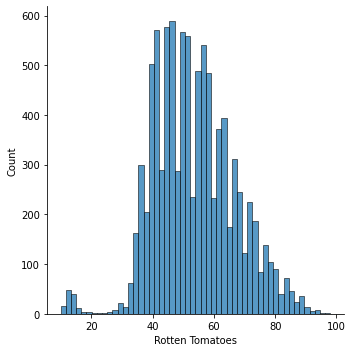

In [ ]:
import seaborn as sns
sns.displot(df[target])

In [ ]:
mean = y_train.mean()
y_train_pred = [mean] * len(y_train)
len(y_train_pred), len(y_train)

(5348, 5348)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
print('score',r2_score(y_train, y_train_pred))
print('mae',mean_absolute_error(y_train, y_train_pred))

score 0.0
mae 10.61340247565269


### Linear Regression / Ridge / PolynomialFeatures + RidgeCV /
### RandomForestRegressor / XGBRegressor Model Selection

In [ ]:
# linear
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())
pipe_linear = Pipeline([('pre', preprocessing), ('linear', LinearRegression())])

pipe_linear.fit(X_train, y_train)
print('train data')
print('score:', pipe_linear.score(X_train, y_train))
print('mae:', mean_absolute_error(y_train, pipe_linear.predict(X_train)))

print('\nval data')
print('score:', pipe_linear.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_linear.predict(X_val)))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


train data
score: 0.5728523389836436
mae: 6.570516789813788

val data
score: 0.47595206094581816
mae: 7.339006021085509


In [ ]:
# ridge
from sklearn.linear_model import Ridge, RidgeCV

pipe_ridge = Pipeline([('pre', preprocessing), ('rdg', Ridge())])

pipe_ridge.fit(X_train, y_train)
print('train data')
print('score:', pipe_ridge.score(X_train, y_train))
print('mae:', mean_absolute_error(y_train, pipe_ridge.predict(X_train)))

print('\nval data')
print('score:', pipe_ridge.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_ridge.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


train data
score: 0.5728523123913756
mae: 6.570502083477562

val data
score: 0.4759466620925746
mae: 7.339064971320709


In [ ]:
# 다항회귀 + CV
from sklearn.preprocessing import PolynomialFeatures

# def RidgeCVRegression(degree=3, **kwargs):
#     return make_pipeline(PolynomialFeatures(degree), RidgeCV(**kwargs))

# alphas = np.arange(0.01, 0.2, 0.01)

pipe_polyridge = Pipeline([('pre', preprocessing), ('poly', PolynomialFeatures()), ('polyridge', RidgeCV(alphas=[0.01, 0.05, 0.1, 0.5, 1, 10]))])

pipe_polyridge.fit(X_train, y_train)
print('train data')
print('score:', pipe_polyridge.score(X_train, y_train))
print('mae:', mean_absolute_error(y_train, pipe_polyridge.predict(X_train)))

print('\nval data')
print('score:', pipe_polyridge.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_polyridge.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


train data
score: 0.6266069689573313
mae: 6.113423327894171

val data
score: 0.519760249131307
mae: 6.862412608160568


In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())
rf = RandomForestRegressor()
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('train data')
print('score:', pipe_rf.score(X_train, y_train))
print('mae:', mean_absolute_error(y_train, pipe_rf.predict(X_train)))

print('\nval data')
print('score:', pipe_rf.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_rf.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


train data
score: 0.9495624721979475
mae: 2.228077830608683

val data
score: 0.5719636309455793
mae: 6.57652515156371


In [ ]:
# xgb
from xgboost import XGBRegressor

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())
xgb = XGBRegressor()
pipe_xgb = Pipeline([('pre', preprocessing), ('xgb', xgb)])

pipe_xgb.fit(X_train, y_train)
print('train data')
print('score:', pipe_xgb.score(X_train, y_train))
print('mae:', mean_absolute_error(y_train, pipe_xgb.predict(X_train)))

print('\nval data')
print('score:', pipe_xgb.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_xgb.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train data
score: 0.6975273000063615
mae: 5.574260432771898

val data
score: 0.5671807620495136
mae: 6.6516848899511825


### RandomFoerst, XGB로 결정. CV를 통해 일반화될 가능성 확인

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

[03:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:57:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[03:58:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


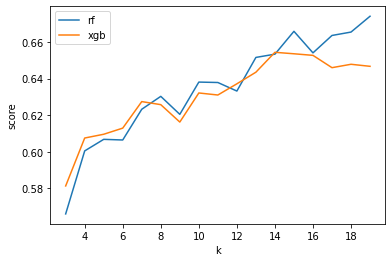

CPU times: user 9min 22s, sys: 2.17 s, total: 9min 24s
Wall time: 9min 22s


In [ ]:
%%time

preprocessing.fit_transform(X_train, y_train)
X_val_ready = preprocessing.transform(X_val)

model_list = []
for model in [pipe_rf, pipe_xgb]:
  score_lst = []
  for k in range(3, 20):
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
    score_lst.append((k,max(scores)))
  model_list.append(score_lst)

rf_x = [x[0] for x in model_list[0]]
rf_y = [x[1] for x in model_list[0]]

xgb_x = [x[0] for x in model_list[1]]
xgb_y = [x[1] for x in model_list[1]]

import matplotlib.pyplot as plt
plt.plot(rf_x, rf_y, label = 'rf')
plt.plot(xgb_x, xgb_y, label = 'xgb')
plt.xlabel('k')
plt.ylabel('score')
plt.legend()
plt.show()

### RandomForest 모델 성능 개선
**[결과]**
- val: 0.5770912900608962
- test: 0.600602973230375

#### Target vs Ordinal
- Target이 성능이 더 좋음

In [ ]:
# Target
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())
rf = RandomForestRegressor()
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('\nval data')
print('score:', pipe_rf.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_rf.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



val data
score: 0.5776375563876646
mae: 6.545671578577215


In [ ]:
# Ordinal
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder

preprocessing = make_pipeline(OrdinalEncoder(), SimpleImputer(), StandardScaler())
rf = RandomForestRegressor()
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('\nval data')
print('score:', pipe_rf.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_rf.predict(X_val)))


val data
score: 0.5058521731393562
mae: 7.286561974200786


#### 랜덤포레스트 + Randomized Search CV

In [ ]:
%%time
# preprocessing부터 
pipe_rf = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(random_state=2)
)

dists = {
    'targetencoder__smoothing': [2.,4., 6., 8., 10., 20.,50.,60.,100.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 50),
    'randomforestregressor__n_estimators': randint(100, 1000), 
    'randomforestregressor__min_samples_leaf': randint(1, 100), 
    'randomforestregressor__max_depth': randint(5, 25), 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}


clf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists, 
    n_iter=100, 
    cv=20, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 81.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 89.7min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 1min 2s, sys: 4.52 s, total: 1min 7s
Wall time: 1h 29min 46s


In [ ]:
clf.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__max_features': 0.49307108203989924,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__n_estimators': 478,
 'targetencoder__min_samples_leaf': 37,
 'targetencoder__smoothing': 20.0}

In [ ]:
clf.score(X_val, y_val)

0.5770912900608962

In [ ]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['Title', 'Directors', 'Genres', 'Country',
                                     'Language'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=37,
                               return_df=True, smoothing=20.0, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy=...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=13,
                                       max_features=0.49307108203989924,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurit

In [ ]:
rf_random_estimator = clf.best_estimator_
rf_random_estimator.fit(X_train_ori, y_train_ori)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['Title', 'Directors', 'Genres', 'Country',
                                     'Language'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=37,
                               return_df=True, smoothing=20.0, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy=...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=13,
                                       max_features=0.49307108203989924,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurit

In [ ]:
rf_random_estimator.score(X_test, y_test)

0.600602973230375

### XGB 모델 성능 개선
[1. Randomized Search CV]
- val: 0.5968687738870462
- test: 0.6213239037917875

[2. Randomized Search CV로 찾은 최적의 파라미터 + early stopping으로 n_estimator 조절]
- val: 0.5948656129962588
- test: 0.6232619566013742

[3. Randomized Search CV로 찾은 최적의 파라미터 중 전처리만 사용 + Randomized Search CV + early stopping]
- val: 0.5783533304101416
- test: 0.6066857448741408


큰 차이가 없음.

#### Taret vs Ordinal
- Target으로 결정

In [ ]:
# Target
from xgboost import XGBRegressor
from category_encoders import TargetEncoder

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())
rf = XGBRegressor()
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('\nval data')
print('score:', pipe_rf.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_rf.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[05:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

val data
score: 0.5671807620495136
mae: 6.6516848899511825


In [ ]:
# Ordinal
from xgboost import XGBRegressor
from category_encoders import OrdinalEncoder

preprocessing = make_pipeline(OrdinalEncoder(), SimpleImputer(), StandardScaler())
rf = XGBRegressor()
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('\nval data')
print('score:', pipe_rf.score(X_val, y_val))
print('mae:', mean_absolute_error(y_val, pipe_rf.predict(X_val)))

[05:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

val data
score: 0.48953477352575664
mae: 7.368567957212199


#### 1. XGB + Randomized Search CV

In [ ]:
%%time
# 랜덤 pipeline 만
pipe_rf = make_pipeline(
    TargetEncoder(), 
    StandardScaler(),
    XGBRegressor(n_estimators = 100, random_state=2)
)

dists = {
    'targetencoder__smoothing': [2.,4., 6., 8., 10., 20.,50.,60.,100.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 50),
    'xgbregressor__max_depth': randint(5, 20), 
    'xgbregressor__learning_rate': list(np.arange(0, 1, 0.001)),
    'xgbregressor__gamma': list(np.arange(0,5,0.5)), 
    'xgbregressor__reg_alpha:': list(np.arange(0,1,0.001)),
    'xgbregressor__reg_lambda': list(np.arange(0,1,0.001))
}

xgb_random = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists, 
    n_iter=100, 
    cv=20, 
    scoring='r2', 
    verbose=1,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train);

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 46.7min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[06:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 45.9 s, sys: 3.72 s, total: 49.6 s
Wall time: 46min 41s


In [ ]:
xgb_random.best_params_

{'targetencoder__min_samples_leaf': 2,
 'targetencoder__smoothing': 50.0,
 'xgbregressor__gamma': 2.0,
 'xgbregressor__learning_rate': 0.115,
 'xgbregressor__max_depth': 6,
 'xgbregressor__reg_alpha:': 0.10400000000000001,
 'xgbregressor__reg_lambda': 0.9470000000000001}

In [ ]:
xgb_random.score(X_val, y_val)

0.5968687738870462

In [ ]:
mean_absolute_error(y_val, xgb_random.predict(X_val))

6.347214284266773

In [ ]:
xgb_random.best_estimator_.fit(X_train_ori, y_train_ori)
xgb_random.best_estimator_.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[08:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6213239037917875

#### 2. XGB + Randomized Search CV로 찾은 최적의 파라미터 + early stopping

In [ ]:
# 랜덤으로 찾은 최적 파라미터에서 early stopping으로 n_estimator 찾기

preprocessing = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 50),StandardScaler()) #standarad 안하면..?
X_train_ready = preprocessing.fit_transform(X_train, y_train)
X_val_ready = preprocessing.transform(X_val)

xgb_earlystopping = XGBRegressor(random_state=2, learning_rate = 0.115, max_depth = 6, reg_alpha = 0.10400000000000001, gamma = 2, reg_lambda = 0.9470000000000001, n_estimators = 1000, n_jobs=-1)

eval_set = [(X_train_ready, y_train), 
            (X_val_ready, y_val)]

xgb_earlystopping.fit(X_train_ready, y_train,
        eval_set = eval_set,
        eval_metric = 'mae',
        early_stopping_rounds=50);

# xgb_earlystopping.score(X_val, y_val)

[08:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:47.0458	validation_1-mae:47.1938
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:41.6593	validation_1-mae:41.8656


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[2]	validation_0-mae:36.8887	validation_1-mae:37.1754
[3]	validation_0-mae:32.6708	validation_1-mae:32.997
[4]	validation_0-mae:28.9392	validation_1-mae:29.3186
[5]	validation_0-mae:25.6377	validation_1-mae:26.0569
[6]	validation_0-mae:22.7216	validation_1-mae:23.1791
[7]	validation_0-mae:20.145	validation_1-mae:20.6318
[8]	validation_0-mae:17.8684	validation_1-mae:18.425
[9]	validation_0-mae:15.8702	validation_1-mae:16.4947
[10]	validation_0-mae:14.1356	validation_1-mae:14.8192
[11]	validation_0-mae:12.6423	validation_1-mae:13.4169
[12]	validation_0-mae:11.357	validation_1-mae:12.2202
[13]	validation_0-mae:10.2666	validation_1-mae:11.2312
[14]	validation_0-mae:9.34963	validation_1-mae:10.4051
[15]	validation_0-mae:8.58826	validation_1-mae:9.71785
[16]	validation_0-mae:7.95463	validation_1-mae:9.1449
[17]	validation_0-mae:7.43891	validation_1-mae:8.67514
[18]	validation_0-mae:7.01642	validation_1-mae:8.29548
[19]	validation_0-mae:6.65458	validation_1-mae:7.98554
[20]	validation_0-mae:6

In [ ]:
xgb_earlystopping.best_score

6.317648

In [ ]:
xgb_earlystopping.score(X_val_ready, y_val)

0.5948656129962588

In [ ]:
xgb_earlystopping.fit(X_train_ori_ready, y_train_ori)
xgb_earlystopping.score(X_test_ready, y_test)

[08:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6232619566013742

#### 3. XGB + Randomized Search CV로 최적의 파라미터 중 전처리만 사용 + Randomized Search CV + early stopping]

In [ ]:
%%time
# 최적 파라미터의 preprocessing + 랜덤 xgb + early stopping

processor = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 50),StandardScaler(), StandardScaler())

X_train_ready = processor.fit_transform(X_train, y_train)
X_val_ready = processor.transform(X_val)
X_test_ready = processor.transform(X_test)
X_train_ori_ready = processor.transform(X_train_ori)

eval_set = [(X_train_ready, y_train), (X_val_ready, y_val)]


dists = {
    'max_depth': randint(5, 20), 
    'learning_rate': list(np.arange(0, 1, 0.001)),
    'gamma': list(np.arange(0,5,0.5)), 
    'reg_alpha:': list(np.arange(0,1,0.001)),
    'reg_lambda': list(np.arange(0,1,0.001))
}

fit_paras = {'early_stopping_rounds':50,
             'eval_set': eval_set,
             'eval_metric': 'mae'
             }

xgb_random_early = RandomizedSearchCV(XGBRegressor(n_estimator = 1000),
                         cv=20,
                         param_distributions = dists,
                         n_iter = 100,
                         scoring = 'r2',
                         n_jobs = -1)
xgb_random_early.fit(X_train_ready, y_train, **fit_paras)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[09:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:50.4221	validation_1-mae:50.5321
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:47.8519	validation_1-mae:48.0026
[2]	validation_0-mae:45.413	validation_1-mae:45.6047
[3]	validation_0-mae:43.0969	validation_1-mae:43.3288
[4]	validation_0-mae:40.8991	validation_1-mae:41.173
[5]	validation_0-mae:38.8142	validation_1-mae:39.1129
[6]	validation_0-mae:36.8353	validation_1-mae:37.1628
[7]	validation_0-mae:34.9573	validation_1-mae:35.3167
[8]	validation_0-mae:33.1751	validation_1-mae:33.5607
[9]	validation_0-mae:31.485	validation_1-mae:31.8985
[10]	validation_0-mae:29.8819	validation_1-mae:30.3055
[11]	validation_0-mae:28.3608	validation_1-mae:28.8184
[12]	validation_0-mae:26.9187	validation_1-mae:27.3831
[13]	validatio

In [ ]:
xgb_random_early.best_params_

{'gamma': 2.0,
 'learning_rate': 0.051000000000000004,
 'max_depth': 5,
 'reg_alpha:': 0.135,
 'reg_lambda': 0.046}

In [ ]:
xgb_random_early.score(X_val_ready, y_val)

0.5783533304101416

In [ ]:
xgb_random_early.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=2.0,
             importance_type='gain', learning_rate=0.051000000000000004,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimator=1000, n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0,
             reg_alpha:=0.135, reg_lambda=0.046, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
processor = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 50),StandardScaler(), StandardScaler())
X_train_ori_ready = processor.fit_transform(X_train_ori, y_train_ori)
X_test_ready = processor.transform(X_test)

xgb_random_early.best_estimator_.fit(X_train_ori_ready, y_train_ori)
xgb_random_early.best_estimator_.score(X_test_ready, y_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[09:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6066857448741408

### 모델 해석

#### XGB -2번

In [ ]:
preprocessing = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 50)) #standarad 안하면..?
X_train_ori_ready = preprocessing.fit_transform(X_train_ori, y_train_ori)
X_test_ready = preprocessing.transform(X_test)

final = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=2,
             importance_type='gain', learning_rate=0.115, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=118,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=2,
             reg_alpha=0.10400000000000001, reg_lambda=0.9470000000000001,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

final.fit(X_train_ori_ready, y_train_ori)
final.score(X_test_ready, y_test)

[09:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6233989202789019

#### Permutation Importances

In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 13.0 MB/s 


In [ ]:
# Permutation Importance로 columimport eli5
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(final,
                                  scoring='r2',
                                  n_iter=5, #다른 random seed를 사용하여 5번 반복
                                  random_state=2)
permuter.fit(X_test_ready, y_test);

In [ ]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.5824 ± 0.0394,IMDb
0.0885 ± 0.0049,Runtime
0.0802 ± 0.0121,Genres
0.0617 ± 0.0085,Country
0.0547 ± 0.0138,Directors
0.0372 ± 0.0087,Prime Video
0.0302 ± 0.0080,Year
0.0258 ± 0.0074,Language
0.0157 ± 0.0067,genre_imdb_top5
0.0103 ± 0.0018,Hulu


#### PDP

In [ ]:
pip install pdpbox

In [ ]:
X_test

,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,genre_imdb_top5,genre_count_top5,director_imdb_top10,director_count_top10,country_imdb_top5,country_count_top5,language_imdb_top5,language_count_top5
9256,Mr. Mouse Takes a Trip,1940,7.2,0,0,0,1,Clyde Geronimi,"Animation,Short,Action,Comedy,Family",United States,English,8.0,0,1,0,0,0,1,0,1
2226,Chamatkar,1992,6.6,1,0,0,0,Rajiv Mehra,"Comedy,Drama,Fantasy",India,Hindi,171.0,0,1,0,0,0,1,0,1
4090,Brian Banks,2019,7.2,0,1,0,0,Tom Shadyac,"Biography,Drama,Sport",United States,English,99.0,1,1,0,0,0,1,0,1
2426,The Girl Allergic to Wi-Fi,2018,6.3,1,0,0,0,Jun Lana,Romance,Philippines,"Filipino,Tagalog",110.0,0,1,0,0,0,0,0,0
9101,Operation Dumbo Drop,1995,5.1,0,0,0,1,Simon Wincer,"Action,Adventure,Comedy,Drama,Family,War",United States,"English,Vietnamese",107.0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,Romance Doll,2020,6.1,1,0,0,0,Yuki Tanada,"Drama,Romance",Japan,Japanese,123.0,0,1,0,0,0,0,0,0
2553,The Reconquest,2016,6.6,1,0,0,0,Jonás Trueba,Drama,Spain,Spanish,108.0,0,1,0,0,0,0,0,1
1970,The Ryan White Story,1989,7.3,1,0,0,0,John Herzfeld,"Biography,Drama",United States,English,105.0,1,1,0,0,0,1,0,1
671,Sabotage,2014,5.7,1,0,0,0,David Ayer,"Action,Crime,Drama,Thriller",United States,"English,Spanish",109.0,0,1,0,0,0,1,0,1


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
X_test_ready.fillna(X_test_ready.mean(), inplace=True)
feature = 'IMDb'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


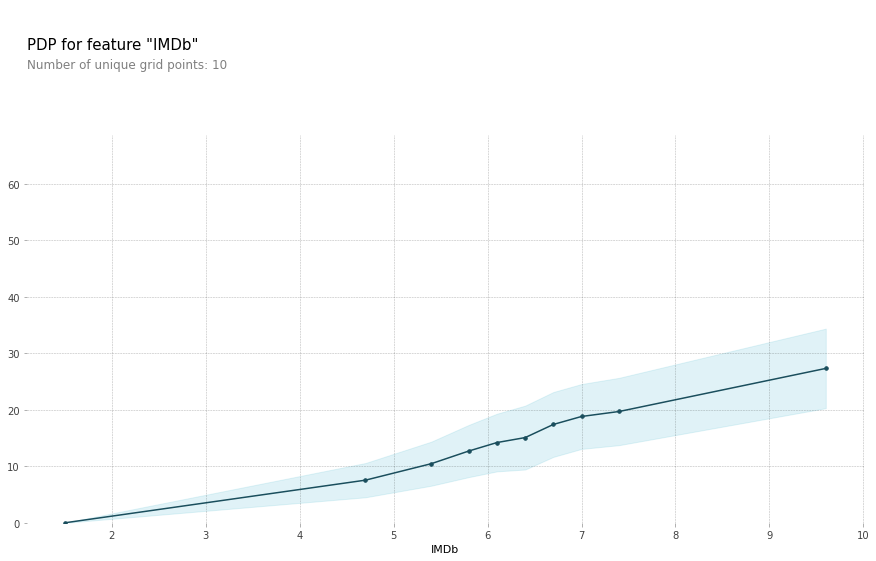

In [ ]:
isolated = pdp_isolate(
    model=final, 
    dataset=X_test_ready, 
    model_features=X_test_ready.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)

pdp_plot(isolated, feature_name=feature);

#### Shap

In [ ]:
pip install shap

In [ ]:
import shap

row = X_test_ready.iloc[[1]]
y_row = y_test.iloc[1]
y_row_pred = final.predict(row)

explainer = shap.TreeExplainer(final)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test_ready.iloc[:500])
shap.force_plot(explainer.expected_value, shap_values, X_test_ready.iloc[:500])

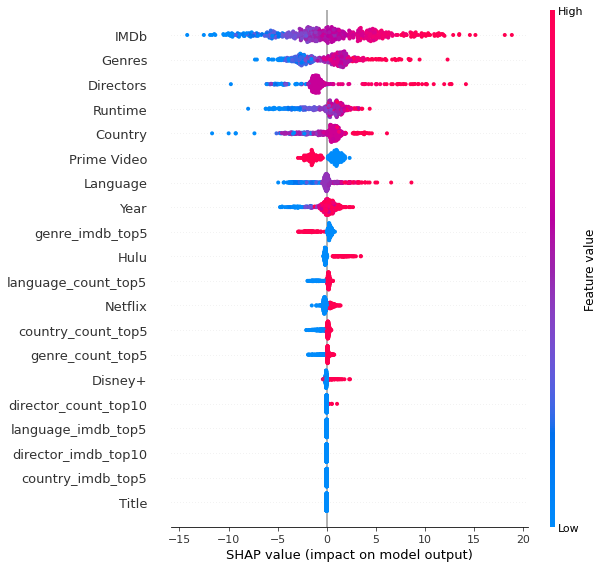

In [ ]:
shap.summary_plot(shap_values, X_test_ready.iloc[:500])

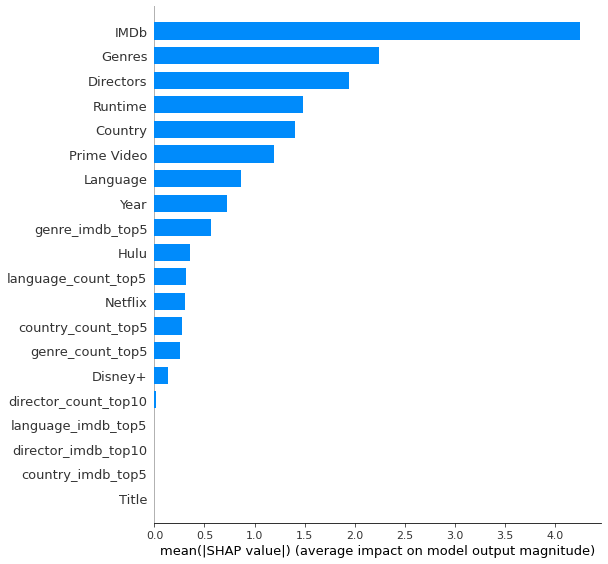

In [ ]:
shap.summary_plot(shap_values, X_test_ready.iloc[:300], plot_type="bar")

우리 회사 영화에 대한 정보


In [ ]:
check = pd.DataFrame(np.array(['Candyman', 2021, 6.4, 84, 0, 0, 0, 0, 'Nia DaCosta', 'Mystery, Thriller, Horror','United States', 'English', 91]))
check = check.T
check.columns = ['Title', 'Year', 'IMDb', 'Rotten Tomatoes', 'Netflix', 'Hulu',
       'Prime Video', 'Disney+', 'Directors', 'Genres', 'Country', 'Language',
       'Runtime']
check

,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,Candyman,2021,6.4,84,0,0,0,0,Nia DaCosta,"Mystery, Thriller, Horror",United States,English,91


In [ ]:
check['genre_imdb_top5'] = check.Genres.apply(lambda x: 1 if any(i in x for i in genre_imdb_top5) else 0)
check['genre_count_top5'] = check.Genres.apply(lambda x: 1 if any(i in x for i in genre_count_top5) else 0)

check['director_imdb_top10'] = check.Directors.apply(lambda x: 1 if any(i in x for i in director_imdb_top10) else 0)
check['director_count_top10'] = check.Directors.apply(lambda x: 1 if any(i in x for i in director_count_top10) else 0)

check['country_imdb_top5'] = check.Country.apply(lambda x: 1 if any(i in x for i in country_imdb_top5) else 0)
check['country_count_top5'] = check.Country.apply(lambda x: 1 if any(i in x for i in country_count_top5) else 0)

check['language_imdb_top5'] = check.Language.apply(lambda x: 1 if any(i in x for i in language_imdb_top5) else 0)
check['language_count_top5'] = check.Language.apply(lambda x: 1 if any(i in x for i in language_count_top5) else 0)

In [ ]:
len(check.columns), len(df.columns)

(21, 21)

In [ ]:
check.iloc[:,1:8] = check.iloc[:,1:8].astype(float)
check.iloc[:, 12] = check.iloc[:, 12].astype(float)
X_check = check.drop(columns=target)
y_check = check[target]

X_check = preprocessing.transform(X_check)
X_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 1 non-null      float64
 1   Year                  1 non-null      float64
 2   IMDb                  1 non-null      float64
 3   Netflix               1 non-null      float64
 4   Hulu                  1 non-null      float64
 5   Prime Video           1 non-null      float64
 6   Disney+               1 non-null      float64
 7   Directors             1 non-null      float64
 8   Genres                1 non-null      float64
 9   Country               1 non-null      float64
 10  Language              1 non-null      float64
 11  Runtime               1 non-null      float64
 12  genre_imdb_top5       1 non-null      int64  
 13  genre_count_top5      1 non-null      int64  
 14  director_imdb_top10   1 non-null      int64  
 15  director_count_top10  1 non

In [ ]:
import shap
X_check = preprocessing.transform(X_check)
y_check_pred = final.predict(X_check)

explainer = shap.TreeExplainer(final)
shap_values = explainer.shap_values(X_check)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_check
)

In [ ]:
y_check

0    84.0
Name: Rotten Tomatoes, dtype: float64

test로 shap

## 시나리오 2
OTT플랫폼인 우리 회사는 어떤 작품과 계약을 맺어야할지 알아보고자 한다.

### 1. 데이터 선정 이유 및 문제 정의
- Rotten Tomatoes에 등록되어 있는 데이터는 영화의 정보(방영년도, 시청률, 평점) 뿐만 아니라 경쟁사가 해당 작품과 계약했는지의 여부까지 확인할 수 있다. 이를 활용하여 target값인 'recommend'를 만들 수 있다.
- 분류 문제로 분석에 접근한다.

### 2. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
[가설]

- 1) Target Encoder가 Ordinal Encoder보다 성능이 좋을 것이다.
- 2) Logistic Regression / RandomForestRegressor / XGBRegressor 중, 랜덤포레스트와 XGB가 성능이 가장 좋을 것이다.
- 3) XGB가 Randomforest보다 성능이 좋을 것이다.

[평가지표]
- auc

[베이스라인]
- target 이 1인 값

### 3. EDA와 데이터 전처리
[기존 feature]
- Age, Type: 제거
- IMDb, Rotten Tomatoes: '/10'제거, float으로 변환
- Gneres, Director, Country, Language: fillna('missing')

[새로운 feature]
- Recommend 추가: IMDb가 7.0 이상, Rotten Tomatoes가 62 이상일 경우 1로 코드.

[데이터 split]
- train, val, test

### 4. 머신러닝 방식 적용 및 교차검증
- 베이스라인 모델 성능 측정
- Linear Regression / RandomForestRegressor / XGBRegressor 모델 학습 후 가장 좋은 성능 2가지 선택
- CV를 통해 일반화 될 가능성이 있는지 시각화
- RandomizedSearchCV를 통해 하이퍼파라미터 조정

### 5. 머신러닝 모델 해석
- Permutation Importances
- PDP
- Shap

### 데이터 가져오기 및 파악하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 999

In [ ]:
import pandas as pd
df_ori = pd.read_csv('/content/drive/MyDrive/AI 부트캠프/section 2/MoviesOnStreamingPlatforms_updated.csv', )
df_ori = df_ori.iloc[:,2:]
df_ori.head()

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [ ]:
df_ori.columns

Index(['Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes', 'Netflix', 'Hulu',
       'Prime Video', 'Disney+', 'Type', 'Directors', 'Genres', 'Country',
       'Language', 'Runtime'],
      dtype='object')

In [ ]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9515 non-null   object 
 1   Year             9515 non-null   int64  
 2   Age              5338 non-null   object 
 3   IMDb             9309 non-null   object 
 4   Rotten Tomatoes  9508 non-null   object 
 5   Netflix          9515 non-null   int64  
 6   Hulu             9515 non-null   int64  
 7   Prime Video      9515 non-null   int64  
 8   Disney+          9515 non-null   int64  
 9   Type             9515 non-null   int64  
 10  Directors        9104 non-null   object 
 11  Genres           9399 non-null   object 
 12  Country          9261 non-null   object 
 13  Language         9202 non-null   object 
 14  Runtime          9196 non-null   float64
dtypes: float64(1), int64(6), object(8)
memory usage: 1.1+ MB


In [ ]:
df_ori.isnull().sum()

Title                 0
Year                  0
Age                4177
IMDb                206
Rotten Tomatoes       7
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors           411
Genres              116
Country             254
Language            313
Runtime             319
dtype: int64

### 전처리

In [ ]:
# Age
df_02 = df_ori.copy()

df_02.drop(columns=['Age','Type'], inplace=True)

df_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9515 non-null   object 
 1   Year             9515 non-null   int64  
 2   IMDb             9309 non-null   object 
 3   Rotten Tomatoes  9508 non-null   object 
 4   Netflix          9515 non-null   int64  
 5   Hulu             9515 non-null   int64  
 6   Prime Video      9515 non-null   int64  
 7   Disney+          9515 non-null   int64  
 8   Directors        9104 non-null   object 
 9   Genres           9399 non-null   object 
 10  Country          9261 non-null   object 
 11  Language         9202 non-null   object 
 12  Runtime          9196 non-null   float64
dtypes: float64(1), int64(5), object(7)
memory usage: 966.5+ KB


#### IMDb, rotten 어쩌고
- '/10'제거
- astype('float')

In [ ]:
df_03 = df_02.copy()

df_03['Rotten Tomatoes'] = [float(score[0:2]) if score == score else None for score in df_03['Rotten Tomatoes']]
df_03['Rotten Tomatoes'].fillna(round(df_03['Rotten Tomatoes'].mean(),2), inplace=True)

df_03.IMDb = [float(score[0:3]) if score == score else None for score in df_03.IMDb]
df_03.IMDb.fillna(round(df_03.IMDb.mean(),2), inplace=True)

df_03.Runtime.fillna(round(df_03.Runtime.mean(),2), inplace=True)

print(df_03.info())
df_03

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9515 non-null   object 
 1   Year             9515 non-null   int64  
 2   IMDb             9515 non-null   float64
 3   Rotten Tomatoes  9515 non-null   float64
 4   Netflix          9515 non-null   int64  
 5   Hulu             9515 non-null   int64  
 6   Prime Video      9515 non-null   int64  
 7   Disney+          9515 non-null   int64  
 8   Directors        9104 non-null   object 
 9   Genres           9399 non-null   object 
 10  Country          9261 non-null   object 
 11  Language         9202 non-null   object 
 12  Runtime          9515 non-null   float64
dtypes: float64(3), int64(5), object(5)
memory usage: 966.5+ KB
None


,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,The Irishman,2019,7.80,98.0,1,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,Dangal,2016,8.40,97.0,1,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,David Attenborough: A Life on Our Planet,2020,9.00,95.0,1,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,Lagaan: Once Upon a Time in India,2001,8.10,94.0,1,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,Roma,2018,7.70,94.0,1,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,Most Wanted Sharks,2020,6.16,14.0,0,0,0,1,NaN,"Crime,Reality-TV",United States,"Greek,English",95.2
9511,Doc McStuffins: The Doc Is In,2020,6.16,13.0,0,0,0,1,Chris Anthony Hamilton,Animation,United States,English,23.0
9512,Ultimate Viking Sword,2019,6.16,13.0,0,0,0,1,NaN,NaN,United States,NaN,95.2
9513,Hunt for the Abominable Snowman,2011,6.16,10.0,0,0,0,1,Dan Oliver,"Drama,History",NaN,NaN,95.2


#### Genres, Director, Country, Language
- fillna('missing')

In [ ]:
df_03.isnull().sum()

Title                0
Year                 0
IMDb                 0
Rotten Tomatoes      0
Netflix              0
Hulu                 0
Prime Video          0
Disney+              0
Directors          411
Genres             116
Country            254
Language           313
Runtime              0
dtype: int64

In [ ]:
df_04 = df_03.copy()
cols = ['Genres', 'Directors', 'Country', 'Language']
df_04[cols] = df_04[cols].fillna('missing')
df_04.isnull().sum()

Title              0
Year               0
IMDb               0
Rotten Tomatoes    0
Netflix            0
Hulu               0
Prime Video        0
Disney+            0
Directors          0
Genres             0
Country            0
Language           0
Runtime            0
dtype: int64

#### 새로운 features
recommendation

In [ ]:
df_04.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Runtime
count,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000
mean,2007.422386,6.156391,53.545018,0.388334,0.110037,0.432265,0.096900,95.199453
std,19.130367,1.150907,13.192817,0.487397,0.312952,0.495417,0.295837,29.152665
min,1914.000000,1.100000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2006.000000,5.500000,44.000000,0.000000,0.000000,0.000000,0.000000,85.000000
50%,2015.000000,6.200000,52.000000,0.000000,0.000000,0.000000,0.000000,95.200000
75%,2018.000000,7.000000,62.000000,1.000000,0.000000,1.000000,0.000000,108.000000
max,2021.000000,9.800000,98.000000,1.000000,1.000000,1.000000,1.000000,566.000000


In [ ]:
recommend_1 = df_04[(df_04.IMDb >= 6.2) & (df_04['Rotten Tomatoes'] >= 52.0)].index
recommend_1

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9195, 9196, 9199, 9201, 9202, 9203, 9205, 9206, 9208, 9209],
           dtype='int64', length=3392)

In [ ]:
df_05= df_04.copy()
df_05['Recommend'] = [1 if x in recommend_1 else 0 for x in df_05.index]
print(df_05.Recommend.value_counts(normalize=True))
df_05

0    0.64351
1    0.35649
Name: Recommend, dtype: float64


,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,Recommend
0,The Irishman,2019,7.80,98.0,1,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0,1
1,Dangal,2016,8.40,97.0,1,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0,1
2,David Attenborough: A Life on Our Planet,2020,9.00,95.0,1,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0,1
3,Lagaan: Once Upon a Time in India,2001,8.10,94.0,1,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0,1
4,Roma,2018,7.70,94.0,1,0,0,0,missing,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,Most Wanted Sharks,2020,6.16,14.0,0,0,0,1,missing,"Crime,Reality-TV",United States,"Greek,English",95.2,0
9511,Doc McStuffins: The Doc Is In,2020,6.16,13.0,0,0,0,1,Chris Anthony Hamilton,Animation,United States,English,23.0,0
9512,Ultimate Viking Sword,2019,6.16,13.0,0,0,0,1,missing,missing,United States,missing,95.2,0
9513,Hunt for the Abominable Snowman,2011,6.16,10.0,0,0,0,1,Dan Oliver,"Drama,History",missing,missing,95.2,0


In [ ]:
df_06 = df_05.drop(columns = ['IMDb', 'Rotten Tomatoes'])
df = df_06.copy()
df

,Title,Year,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,Recommend
0,The Irishman,2019,1,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0,1
1,Dangal,2016,1,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0,1
2,David Attenborough: A Life on Our Planet,2020,1,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0,1
3,Lagaan: Once Upon a Time in India,2001,1,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0,1
4,Roma,2018,1,0,0,0,missing,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9510,Most Wanted Sharks,2020,0,0,0,1,missing,"Crime,Reality-TV",United States,"Greek,English",95.2,0
9511,Doc McStuffins: The Doc Is In,2020,0,0,0,1,Chris Anthony Hamilton,Animation,United States,English,23.0,0
9512,Ultimate Viking Sword,2019,0,0,0,1,missing,missing,United States,missing,95.2,0
9513,Hunt for the Abominable Snowman,2011,0,0,0,1,Dan Oliver,"Drama,History",missing,missing,95.2,0


In [ ]:
df[target].value_counts(normalize=True)

0    0.64351
1    0.35649
Name: Recommend, dtype: float64

### 데이터 split

In [ ]:
from sklearn.model_selection import train_test_split
target = 'Recommend'
# train, val, test
def split(df):
  train_ori, test = train_test_split(df)
  train, val = train_test_split(train_ori)
  print(len(train), len(val), len(train_ori), len(test))

  X_train = train.drop(columns=target)
  y_train = train[target]

  X_val = val.drop(columns=target)
  y_val = val[target]

  X_test = test.drop(columns=target)
  y_test = test[target]

  X_train_ori = train_ori.drop(columns=target)
  y_train_ori = train_ori[target]

  return X_train, y_train, X_val, y_val, X_test, y_test, X_train_ori, y_train_ori

X_train, y_train, X_val, y_val, X_test, y_test, X_train_ori, y_train_ori = split(df)

5352 1784 7136 2379


### 기본모델

In [ ]:
# pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 4.1 MB/s 


In [ ]:
from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [ ]:
y_train.value_counts(normalize=True)

0    0.633221
1    0.366779
Name: Recommend, dtype: float64

In [ ]:
y_train_pred = [0] * len(y_train)
len(y_train_pred), len(y_train)

(5352, 5352)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, f1_score, accuracy_score
print('accuracy:', accuracy_score(y_train, y_train_pred))
print('f1:',f1_score(y_train, y_train_pred))
print('auc:', roc_auc_score(y_train, y_train_pred) )

accuracy: 0.6332212257100149
f1: 0.0
auc: 0.5


### Logistic Regression / RandomForestClassifier / XGBClassifier

In [ ]:
# Logistic
preprocessing = make_pipeline(TargetEncoder())
pipe_logistic = Pipeline([('pre', preprocessing), ('linear', LogisticRegression(random_state=2))])

pipe_logistic.fit(X_train, y_train)
print('\ntrain data')
print('accuracy:', pipe_logistic.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_logistic.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_logistic.predict(X_train)))

print('\nval data')
print('accuracy:', pipe_logistic.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_logistic.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_logistic.predict(X_val)))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train data
accuracy: 0.7802690582959642
f1: 0.6632302405498282
auc: 0.7402207886321859

val data
accuracy: 0.7118834080717489
f1: 0.47657841140529533
auc: 0.6328531897054892


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier

preprocessing = make_pipeline(TargetEncoder())
rf = RandomForestClassifier(random_state=2)
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('\ntrain data')
print('accuracy:', pipe_rf.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_rf.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_rf.predict(X_train)))

print('\nval data')
print('accuracy:', pipe_rf.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_rf.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_rf.predict(X_val)))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train data
accuracy: 0.9975710014947683
f1: 0.9966862095335202
auc: 0.9972246218662849

val data
accuracy: 0.7130044843049327
f1: 0.5469026548672566
auc: 0.6636213868503817


In [ ]:
# xgb
from xgboost import XGBClassifier

preprocessing = make_pipeline(TargetEncoder())
xgb = XGBClassifier(random_state=2)
pipe_xgb = Pipeline([('pre', preprocessing), ('xgb', xgb)])

pipe_xgb.fit(X_train, y_train)
print('\ntrain data')
print('accuracy:', pipe_xgb.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_xgb.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_xgb.predict(X_train)))


print('\nval data')
print('accuracy:', pipe_xgb.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_xgb.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_xgb.predict(X_val)))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train data
accuracy: 0.7944693572496263
f1: 0.6820809248554913
auc: 0.7537914083907257

val data
accuracy: 0.7253363228699552
f1: 0.5224171539961014
auc: 0.6566116911310832


### 세 모델 모두 CV를 통한 교차검증으로 일반화될 가능성 확인
- RandomForest, XGB로 결정

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

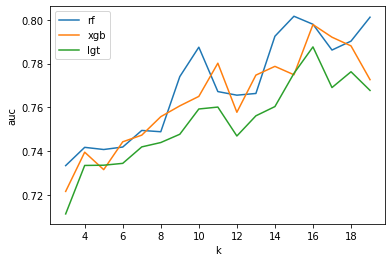

In [ ]:
from sklearn.model_selection import cross_val_score

preprocessing.fit_transform(X_train, y_train)
X_val_ready = preprocessing.transform(X_val)

model_list = []
for model in [pipe_rf, pipe_xgb, pipe_logistic]:
  score_lst = []
  for k in range(3, 20):
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring='roc_auc')
    score_lst.append((k,max(scores)))
  model_list.append(score_lst)

rf_x = [x[0] for x in model_list[0]]
rf_y = [x[1] for x in model_list[0]]

xgb_x = [x[0] for x in model_list[1]]
xgb_y = [x[1] for x in model_list[1]]

lgt_x = [x[0] for x in model_list[2]]
lgt_y = [x[1] for x in model_list[2]]


import matplotlib.pyplot as plt
plt.plot(rf_x, rf_y, label = 'rf')
plt.plot(xgb_x, xgb_y, label = 'xgb')
plt.plot(lgt_x, lgt_y, label= 'lgt')
plt.xlabel('k')
plt.ylabel('auc')
plt.legend()
plt.show()

### 랜덤포레스트 모델 성능 개선

- val: 0.6471413234719828
- test: 0.6255244738853025

#### Target > Ordinal

In [ ]:
# Target
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder

preprocessing = make_pipeline(TargetEncoder())
rf = RandomForestClassifier(random_state=2)
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('train data')
print('accuracy:', pipe_rf.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_rf.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_rf.predict(X_train)))

print('\nval data')
print('accuracy:', pipe_rf.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_rf.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_rf.predict(X_val)))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


train data
accuracy: 0.9975710014947683
f1: 0.9966862095335202
auc: 0.9972246218662849

val data
accuracy: 0.7130044843049327
f1: 0.5469026548672566
auc: 0.6636213868503817


In [ ]:
# Ordinal
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder

preprocessing = make_pipeline(OrdinalEncoder())
rf = RandomForestClassifier(random_state=2)
pipe_rf = Pipeline([('pre', preprocessing), ('rf', rf)])

pipe_rf.fit(X_train, y_train)
print('train data')
print('accuracy:', pipe_rf.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_rf.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_rf.predict(X_train)))


print('\nval data')
print('accuracy:', pipe_rf.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_rf.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_rf.predict(X_val)))


train data
accuracy: 1.0
f1: 1.0
auc: 1.0

val data
accuracy: 0.5919282511210763
f1: 0.41666666666666663
auc: 0.5523158730136513


#### 랜덤포레스트 + RandomizedSearchCV

Randomized Search CV

In [ ]:
%%time
pipe_rf = make_pipeline(
    TargetEncoder(), 
    RandomForestClassifier(random_state=2, n_jobs=-1)
)

dists = {
    'targetencoder__smoothing': [2.,4., 6., 8., 10., 20.,50.,60.,100.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 50),
    'randomforestclassifier__n_estimators': randint(100, 1000), 
    'randomforestclassifier__min_samples_leaf': randint(1, 100),
    'randomforestclassifier__min_samples_split': randint(1, 100), 
    'randomforestclassifier__max_depth': randint(-1, 20), 
    'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

rf_random_clf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists, 
    n_iter=100, 
    cv=20, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

rf_random_clf.fit(X_train, y_train);

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 61.6min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 45 s, sys: 2.79 s, total: 47.8 s
Wall time: 1h 1min 38s


In [ ]:
rf_random_clf.best_params_

{'randomforestclassifier__max_depth': 17,
 'randomforestclassifier__max_features': 0.1063673295635339,
 'randomforestclassifier__min_samples_leaf': 14,
 'randomforestclassifier__min_samples_split': 39,
 'randomforestclassifier__n_estimators': 546,
 'targetencoder__min_samples_leaf': 7,
 'targetencoder__smoothing': 4.0}

In [ ]:
rf_random_clf.score(X_val, y_val) #accuracy

0.7574355543300408

In [ ]:
roc_auc_score(y_val, rf_random_clf.best_estimator_.predict(X_val))

0.6471413234719828

In [ ]:
rf_random_clf.best_estimator_.fit(X_train_ori, y_train_ori)
roc_auc_score(y_test, rf_random_clf.best_estimator_.predict(X_test))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.6255244738853025

### XGB 모델 성능 개선
[1. XGB + RandomizedSearchCV]
- val: 0.6623105681520746
- test: 0.6721657314037383

[2. XGB + Randomized Search CV로 찾은 최적의 파라미터 + early stopping]
- val:0.673972165573268
- test:0.6711343637633668
 

#### Target > Ordinal

In [ ]:
# Target
preprocessing = make_pipeline(TargetEncoder())
xgb = XGBClassifier(random_state=2)
pipe_xgb = Pipeline([('pre', preprocessing), ('xgb', xgb)])

pipe_xgb.fit(X_train, y_train)

print('\nval data')
print('accuracy:', pipe_xgb.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_xgb.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_xgb.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



val data
accuracy: 0.7253363228699552
f1: 0.5224171539961014
auc: 0.6566116911310832


In [ ]:
# Ordinal
preprocessing = make_pipeline(OrdinalEncoder())
xgb = XGBClassifier(random_state=2)
pipe_xgb = Pipeline([('pre', preprocessing), ('xgb', xgb)])

pipe_xgb.fit(X_train, y_train)

print('\nval data')
print('accuracy:', pipe_xgb.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_xgb.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_xgb.predict(X_val)))


val data
accuracy: 0.7045964125560538
f1: 0.42024202420242024
auc: 0.6101773559394154


#### 1. XGB + RandomizedSearchCV

In [ ]:
%%time
#class weight 안준버전, 밑에는 class weight 준 버전
pipe_xgb = make_pipeline(
    TargetEncoder(), 
    XGBClassifier(random_state = 2, n_estimators=100)
)

dists = {
    'targetencoder__smoothing': [2.,4., 6., 8., 10., 20.,50.,60.,100.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 50),
    'xgbclassifier__max_depth': randint(5, 20), 
    'xgbclassifier__learning_rate': list(np.arange(0, 1, 0.001)),
    'xgbclassifier__gamma': list(np.arange(0,5,0.5)), 
    'xgbclassifier__reg_alpha:': list(np.arange(0,1,0.001)),
    'xgbclassifier__reg_lambda': list(np.arange(0,1,0.001))
}


xgb_random_clf = RandomizedSearchCV(
    pipe_xgb, 
    param_distributions=dists, 
    n_iter=100, 
    cv=20, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

xgb_random_clf.fit(X_train, y_train);

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 29.0min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 35.2 s, sys: 1.85 s, total: 37.1 s
Wall time: 29min 1s


In [ ]:
xgb_random_clf.best_params_

{'targetencoder__min_samples_leaf': 17,
 'targetencoder__smoothing': 10.0,
 'xgbclassifier__gamma': 3.0,
 'xgbclassifier__learning_rate': 0.211,
 'xgbclassifier__max_depth': 10,
 'xgbclassifier__reg_alpha:': 0.705,
 'xgbclassifier__reg_lambda': 0.7010000000000001}

In [ ]:
xgb_random_clf.score(X_val, y_val)

0.7480757629412726

In [ ]:
roc_auc_score(y_val, xgb_random_clf.predict(X_val))

0.6623105681520746

In [ ]:
xgb_random_clf.best_estimator_.fit(X_train_ori,y_train_ori)
roc_auc_score(y_test, xgb_random_clf.best_estimator_.predict(X_test))

0.6721657314037383

임계치 조정하기

In [ ]:
# 임계치 조정하기
from sklearn.metrics import roc_curve, roc_auc_score

y_val_predict = xgb_random_clf.predict(X_val_ready)
y_val_predict_proba = xgb_random_clf.predict_proba(X_val_ready)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_predict_proba )

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_val_predict_optimal = y_val_predict >= optimal_threshold
best_auc_score = roc_auc_score(y_val, y_val_predict_optimal)
best_auc_score


0.6414802383408521

#### 2. XGB + Randomized Search CV로 찾은 최적의 파라미터 + early stopping

In [ ]:
# 랜덤으로 찾은 최적 파라미터에서 early stopping으로 n_estimator 찾기

preprocessing = make_pipeline(TargetEncoder(min_samples_leaf = 17, smoothing = 10))
X_train_ready = preprocessing.fit_transform(X_train, y_train)
X_val_ready = preprocessing.transform(X_val)
'''
X_train_ori_ready = preprocessing.transform(X_train_ori)
X_test_ready = preprocessing.transform(X_test)
'''

xgb_random_early = XGBClassifier(random_state=2, learning_rate = 0.211, max_depth = 10, 
                    gamma = 3, reg_alpha=0.705, reg_lambda=0.701, n_estimators = 1000, n_jobs=-1)

eval_set = [(X_train_ready, y_train), 
            (X_val_ready, y_val)]

xgb_random_early.fit(X_train_ready, y_train,
        eval_set = eval_set,
        eval_metric = 'auc',
        early_stopping_rounds=50);

[0]	validation_0-auc:0.867526	validation_1-auc:0.705339
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.877798	validation_1-auc:0.715701
[2]	validation_0-auc:0.884039	validation_1-auc:0.72466


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[3]	validation_0-auc:0.890283	validation_1-auc:0.729554
[4]	validation_0-auc:0.893915	validation_1-auc:0.731194
[5]	validation_0-auc:0.898147	validation_1-auc:0.734086
[6]	validation_0-auc:0.89934	validation_1-auc:0.73393
[7]	validation_0-auc:0.901227	validation_1-auc:0.73486
[8]	validation_0-auc:0.902745	validation_1-auc:0.736621
[9]	validation_0-auc:0.904782	validation_1-auc:0.738155
[10]	validation_0-auc:0.9059	validation_1-auc:0.738733
[11]	validation_0-auc:0.908728	validation_1-auc:0.740016
[12]	validation_0-auc:0.910295	validation_1-auc:0.740314
[13]	validation_0-auc:0.91161	validation_1-auc:0.7403
[14]	validation_0-auc:0.913273	validation_1-auc:0.741088
[15]	validation_0-auc:0.913947	validation_1-auc:0.741876
[16]	validation_0-auc:0.914556	validation_1-auc:0.741878
[17]	validation_0-auc:0.916066	validation_1-auc:0.743919
[18]	validation_0-auc:0.917948	validation_1-auc:0.744659
[19]	validation_0-auc:0.917976	validation_1-auc:0.745257
[20]	validation_0-auc:0.919575	validation_1-au

In [ ]:
xgb_random_early.score(X_val_ready, y_val)

0.7281390134529148

In [ ]:
xgb_random_early

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.211, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0.705, reg_lambda=0.701, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
roc_auc_score(y_val, xgb_random_early.predict(X_val_ready))

0.6722988246722253

In [ ]:
xgb_random_early_stopping = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.211, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=43, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0.705, reg_lambda=0.701, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb_random_early_stopping.fit(X_train_ready, y_train)
print(roc_auc_score(y_val,xgb_random_early_stopping.predict(X_val_ready)))
print(roc_auc_score(y_test, xgb_random_early_stopping.predict(X_test_ready)))


0.673972165573268
0.618289664289833


train_ori로 보기

In [ ]:
X_train_ori_ready = preprocessing.fit_transform(X_train_ori, y_train_ori)
X_test_ready = preprocessing.transform(X_test)

xgb_random_early_stopping.fit(X_train_ori_ready, y_train_ori)
roc_auc_score(y_test, xgb_random_early_stopping.predict(X_test_ready))

0.6711343637633668

임계치 조정

In [ ]:
# 임계치 조정하기
from sklearn.metrics import roc_curve, roc_auc_score

y_val_predict = xgb_random_early_stopping.predict(X_val_ready)
y_val_predict_proba = xgb_random_early_stopping.predict_proba(X_val_ready)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_predict_proba )

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_val_predict_optimal = y_val_predict >= optimal_threshold
best_auc_score = roc_auc_score(y_val, y_val_predict_optimal)
best_auc_score


0.673972165573268

### 모델 해석

#### XGB

In [ ]:
xgb_random_clf.best_estimator_.fit(X_train_ori, y_train_ori)
roc_auc_score(y_test, xgb_random_clf.best_estimator_.predict(X_test))

0.6721657314037383

In [ ]:
encoder = xgb_random_clf.best_estimator_.named_steps['targetencoder']
final = xgb_random_clf.best_estimator_.named_steps['xgbclassifier']

In [ ]:
X_train_ori_encoded = encoder.fit_transform(X_train_ori, y_train_ori)
X_test_encoded = encoder.fit_transform(X_test, y_test)

final.fit(X_train_ori_encoded, y_train_ori)
roc_auc_score(y_test, final.predict(X_test_encoded))

0.6344551800439737

#### Permutation Importances

In [ ]:
pip install eli5

In [ ]:
encoder = TargetEncoder(cols=['Title', 'Directors', 'Genres', 'Country',
                                     'Language'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=17,
                               return_df=True, smoothing=10.0, verbose=0)

encoder.fit_transform(X_train_ori, y_train_ori)
X_test_encoded = encoder.fit_transform(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# Permutation Importance로 columimport eli5
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(final,
                                  scoring='roc_auc',
                                  n_iter=5, #다른 random seed를 사용하여 5번 반복
                                  random_state=2)
permuter.fit(X_test_encoded, y_test);

In [ ]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0806 ± 0.0193,Directors
0.0797 ± 0.0120,Genres
0.0275 ± 0.0053,Runtime
0.0157 ± 0.0085,Year
0.0154 ± 0.0021,Netflix
0.0139 ± 0.0047,Language
0.0108 ± 0.0054,Prime Video
0.0084 ± 0.0030,Hulu
0.0082 ± 0.0035,Country
0.0005 ± 0.0007,Disney+


#### PDP

In [ ]:
pip install pdpbox

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
X_test_ready.fillna(X_test_ready.mean(), inplace=True)
feature = 'Directors'

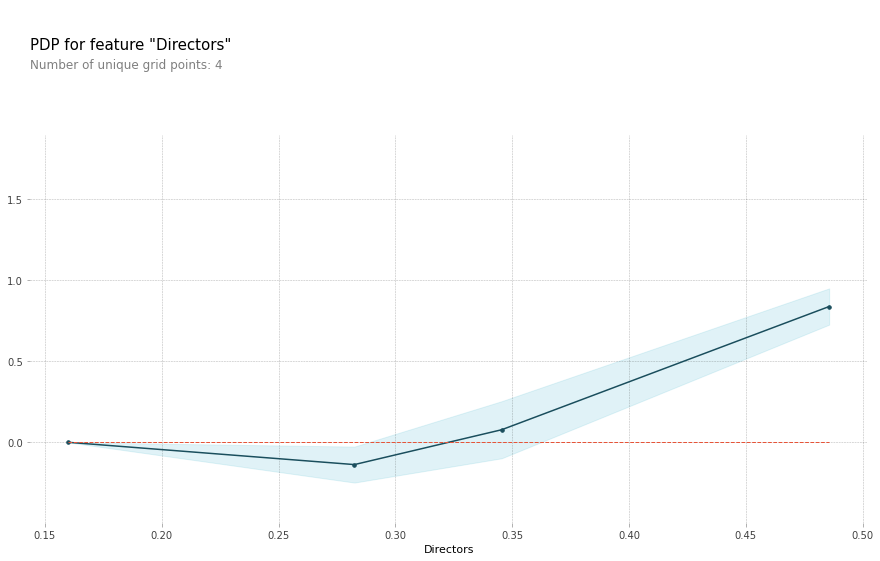

In [ ]:
isolated = pdp_isolate(
    model=final, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)

pdp_plot(isolated, feature_name=feature);

#### Shap

In [ ]:
pip install shap

In [ ]:
import shap

row = X_test_encoded.iloc[[1]]
y_row = y_test.iloc[1]
y_row_pred = final.predict(row)

explainer = shap.TreeExplainer(final)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test_encoded.iloc[:500])
shap.force_plot(explainer.expected_value, shap_values, X_test_encoded.iloc[:500])

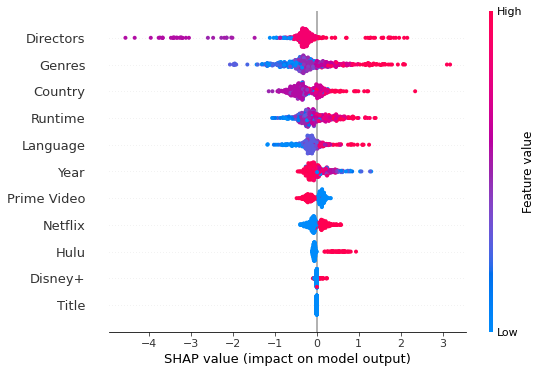

In [ ]:
shap.summary_plot(shap_values, X_test_encoded.iloc[:500])

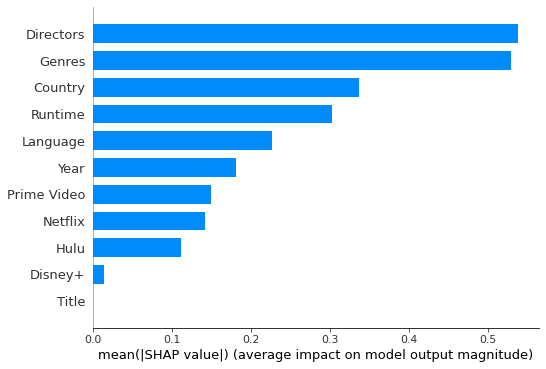

In [ ]:
shap.summary_plot(shap_values, X_test_encoded.iloc[:300], plot_type="bar")